### STEP 1.  Define ARIMA Analysis and Utility Functions

A function that performs a kind of hyperarameter search for ARIMA models (*get.best.arima*) is defined.
Helper function which build a model from its search sresult is also defined.
Utiliyt functions that compute RMSE, fetch data, and plot are also defined.

In [1]:
# this get.best.arima was done as part of group homework in W271 and is incorporated here
# I, Eddie Salinas, was in the group.
#BrittanyDougall_SteveHall_PrabhuNarsina_EdwardSalinas_Lab2.Rmd (line 373)
get.best.arima <- function(x.ts, maxord = c(1,1,1,1,1,1))
{
    best.aic <- 1e8
    df.results = data.frame()
    n<-length(x.ts)
    for(p in 0:maxord[1]) for(d in 0:maxord[2]) for(q in 0:maxord[3])
      for(P in 0:maxord[4]) for(D in 0:maxord[5]) for(Q in 0:maxord[6])
      {
        tryCatch(
        {
          fit <- arima(x.ts, order=c(p,d,q),
                             seas = list(order=c(P,D,Q), frequency(x.ts)), 
                                         method="ML")
          
          npar <- length(fit$coef[fit$mask]) + 1
          nstar <- length(fit$residuals) - fit$arma[6] - fit$arma[7]*fit$arma[5]
  
          fit.aic <- fit$aic
          fit.bic <- fit.aic + npar * (log(nstar) - 2)
          fit.aicc <- fit.aic + 2 * npar * (nstar/(nstar - npar - 1) - 1)
          
          df <- data.frame(model= paste(p,d,q,P,D,Q), AICc= fit.aicc,
                           AIC= fit.aic, BIC= fit.bic)
          df.results <- rbind(df.results, df)
        },
        error=function(cond) {
            paste('Error with [', p,',',d,',',q,']', '[', P,',',D,',',Q,']')
        }
        )
      }
    #df.results
    df.results<-df.results[order(df.results$AICc),]
    #print("df.results")
    #print(head(df.results))
    df.results
}

#Given a model result from the search above, compute an arima from the specifications
#it returns
getArimapdqPDQFromModelStr=function(ms,data) {
    tba_params=unlist(strsplit(ms," "))
    #print(paste("tba_params",tba_params))
    p=as.integer(tba_params[1])
    d=as.integer(tba_params[2])
    q=as.integer(tba_params[3])
    P=as.integer(tba_params[4])
    D=as.integer(tba_params[5])
    Q=as.integer(tba_params[6])
    #print(P)
    #print(D)
    #print(Q)
    the_arima=arima(data, order=c(p,d,q), seas = list(order=c(P,D,Q),12),method="ML")
    return(the_arima)
}

In [2]:
library(tseries)
library(forecast)
getTSDataFromFileAll=function(in_file,num_mos=12) {
    cdd=read.delim(in_file,header=TRUE)
    if(dim(cdd)[1]!=168) {
        stop(paste("Read ",length(cdd)," rows of data, but expected 168 rows of data!"))
    }
    num_rows_tot=num_mos
    cdd_for_ts=cdd[1:num_rows_tot,]
    cddts=ts(cdd_for_ts, start=c(2003,1),frequency=12) 
    return(cddts)   
}




getSiteNameFromFile=function(f) {
    df=read.csv(f,header=TRUE)
    site_name=colnames(df)[1]
    if(startsWith(site_name,"X")) {
        site_name=substring(site_name, 2)
    }
    return(site_name)
}

RMSECalc=function(actual,predicted) {
    residuals=actual-predicted
    sq_residuals=residuals^2
    mean_sq_residuals=mean(sq_residuals)
    root_mean_sq_residuals=sqrt(mean_sq_residuals)
    return(root_mean_sq_residuals)
}


plotThem=function(all_data,train_data,pred_data_a,pred_data_b,main_title) {
    twelths=seq(from=2003.0,to=2016+(23.0/24.0),by=1.0/12.0)
    #all data
    x_all=twelths
    y_all=all_data
    
    #train data (assumed to be prefix of all data)
    num_train=length(train_data)
    x_train=twelths[c(1:num_train)]
    y_train=train_data
    
    #prediction data a (assumed to start immediately after train)
    num_pred=length(pred_data_a)
    pred_idx=(num_train+1):(num_train+num_pred)
    x_pred_a=twelths[pred_idx]
    y_pred_a=pred_data_a
    
    #prediction data b (assumed to start immediately after train)
    x_pred_b=twelths[pred_idx]
    y_pred_b=pred_data_b
    
    #calc RMSEs
    pred_a_rmse=round(RMSECalc(y_all[pred_idx],y_pred_a),2)
    pred_b_rmse=round(RMSECalc(y_all[pred_idx],y_pred_b),2)
    
    
    #do the plotting
    temp_y_data=unlist(c(y_all,y_pred_a,y_pred_b))
    ylim_top=max(temp_y_data)+5
    plot(x=x_all,y=y_all,type="l",main=main_title,
         ylim=c(max(min(temp_y_data)-5,0),ylim_top),
         xlab="Year",ylab="Well Measurement (Ft.)"
        )
    lines(x=x_pred_a,y=y_pred_a,col="red",type="l")
    lines(x=x_pred_b,y=y_pred_b,col="blue",type="l")
    legend(x="topleft", legend=c("Measurement",
                                 paste("Auto.Arima ; RMSE=",pred_a_rmse,sep=""),
                                 paste("Model Search(AICc) ; RMSE=",pred_b_rmse,sep="")),
       col=c("black","red", "blue"), lty=1, cex=0.8)
    
    rmse_package=c(pred_a_rmse,pred_b_rmse) 
    rmse_with_reals=c(rmse_package,y_all[pred_idx])
    return(rmse_with_reals)
    
    
}


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



### STEP 2.  Fit Models and Plot Results

For several years fit models and generate predictions for the 6-month period April-September.  Tally results along the way.

In [3]:
cnra_dir="./CNRA_data/"
cnra_glob=paste(cnra_dir,"*W+([0-9]).csv",sep="")
cnra_glob=paste(cnra_dir,"*W00*.csv",sep="")
cnra_files=Sys.glob(cnra_glob, dirmark = TRUE)
print(cnra_files)

[1] "./CNRA_data/340033N1170693W001.csv" "./CNRA_data/353890N1191471W001.csv"
[3] "./CNRA_data/373177N1219435W005.csv" "./CNRA_data/373922N1183430W001.csv"


[1] 2013
[1] "rmse auto  4.6  RMSE best  6.35"
[1] "########################################"
[1] 2013


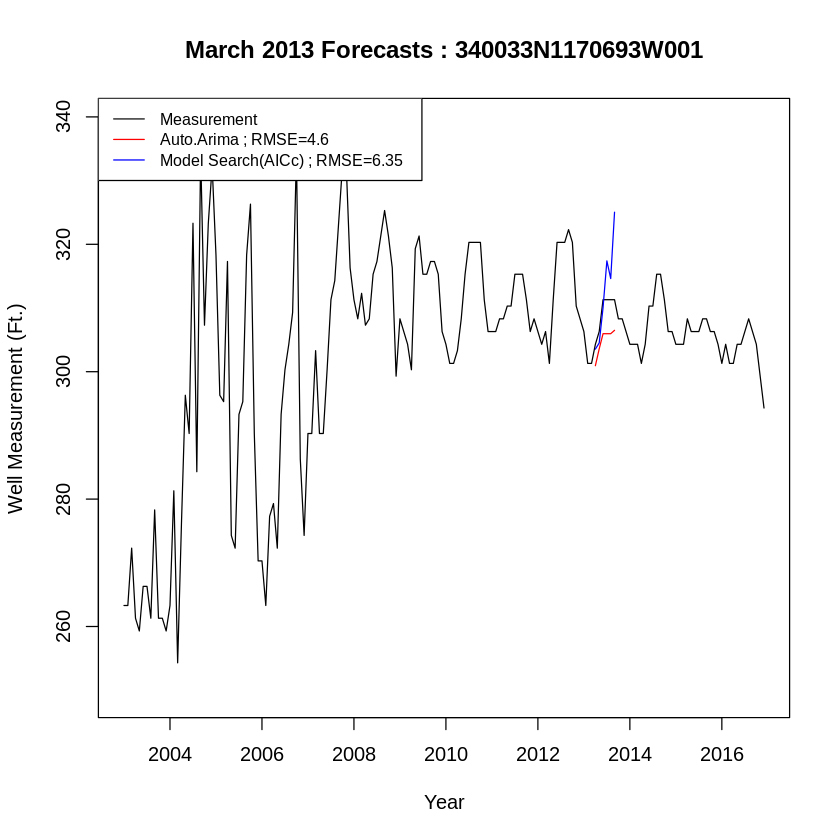

[1] "rmse auto  8.13  RMSE best  6.79"
[1] "########################################"
[1] 2013


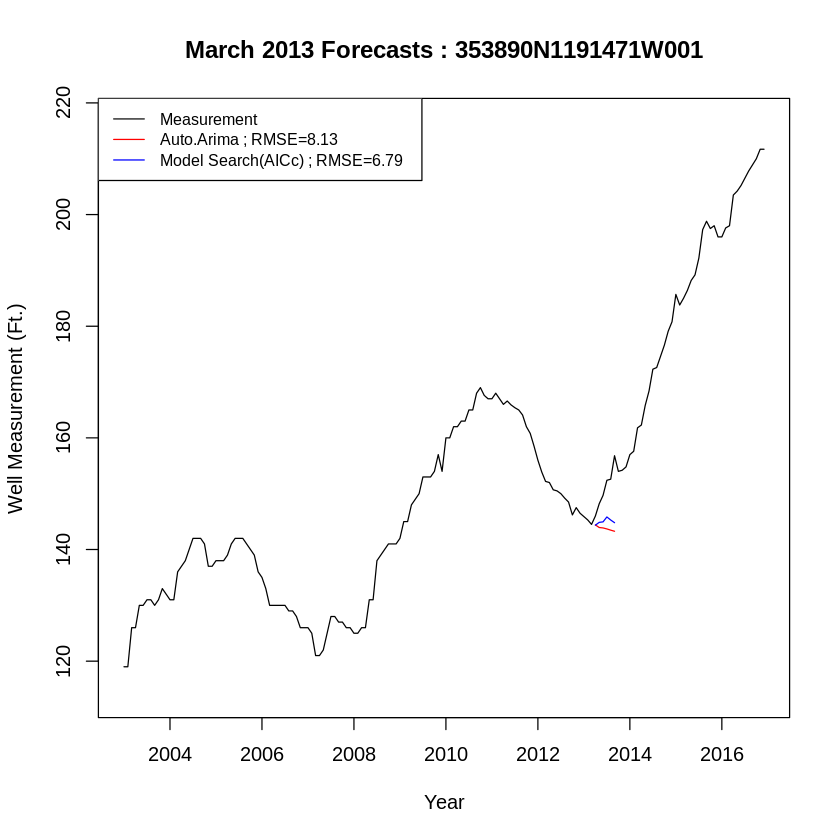

[1] "rmse auto  3.35  RMSE best  3.44"
[1] "########################################"
[1] 2013


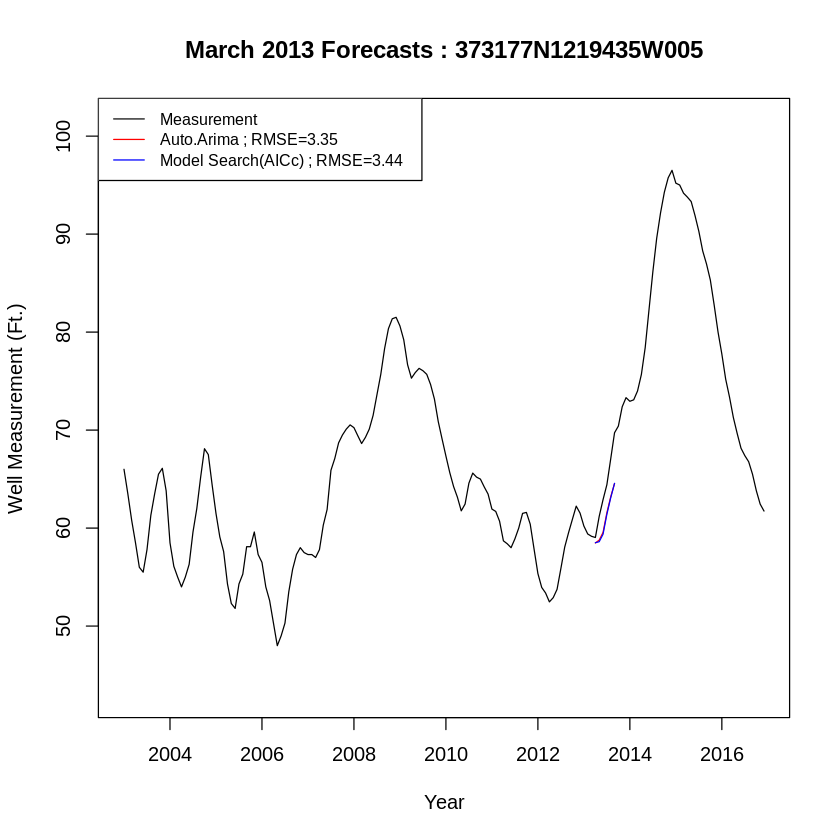

[1] "rmse auto  1.72  RMSE best  0.39"
[1] "########################################"
[1] 2014


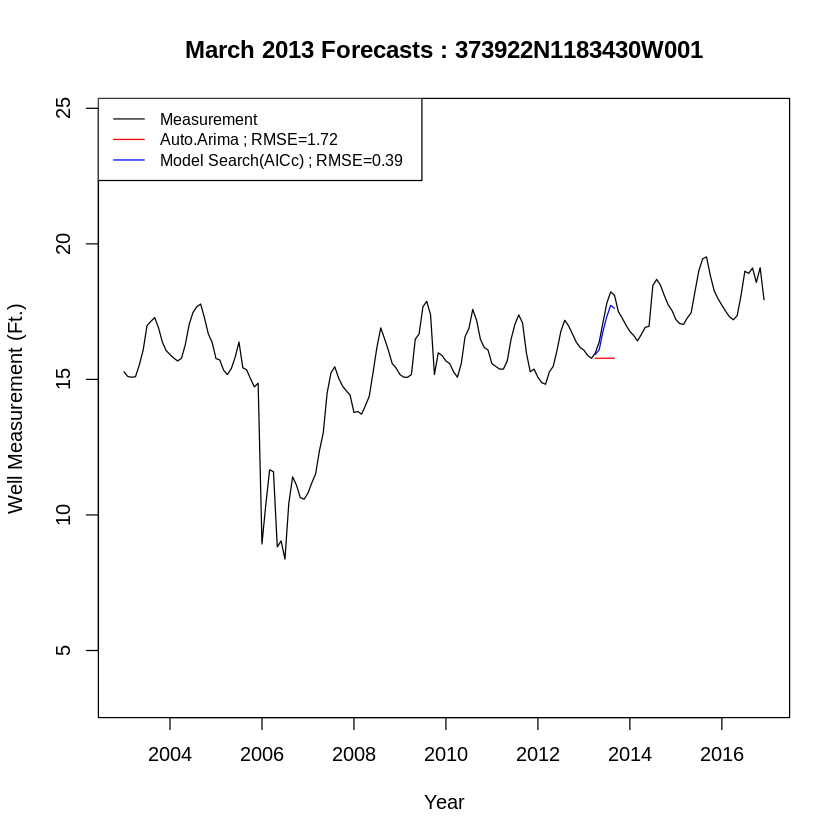

[1] "rmse auto  5.48  RMSE best  4.79"
[1] "########################################"
[1] 2014


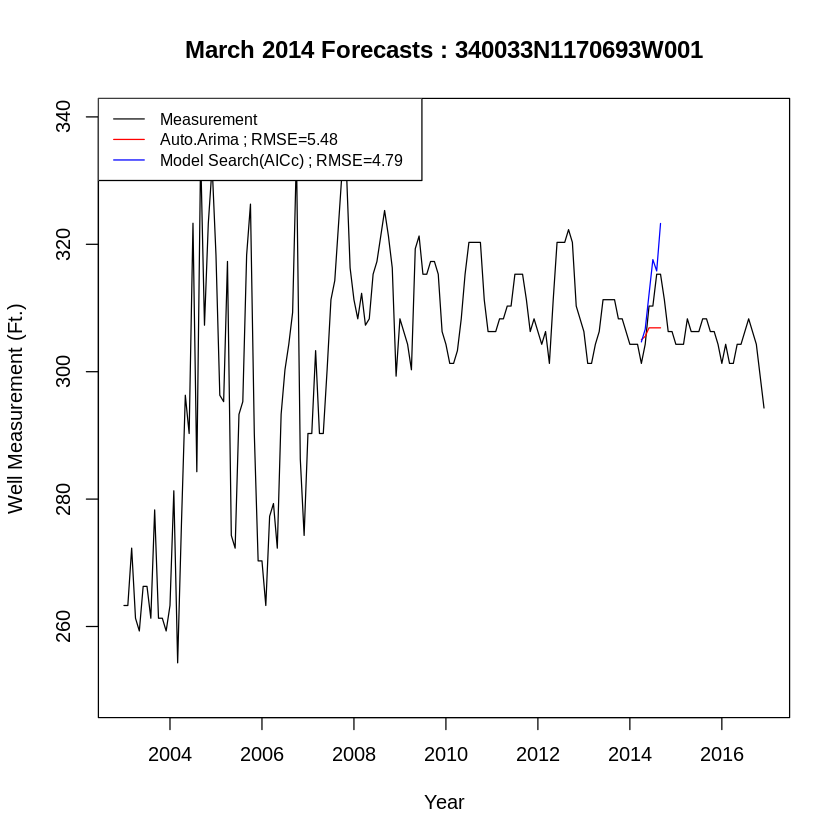

[1] "rmse auto  4.09  RMSE best  0.77"
[1] "########################################"
[1] 2014


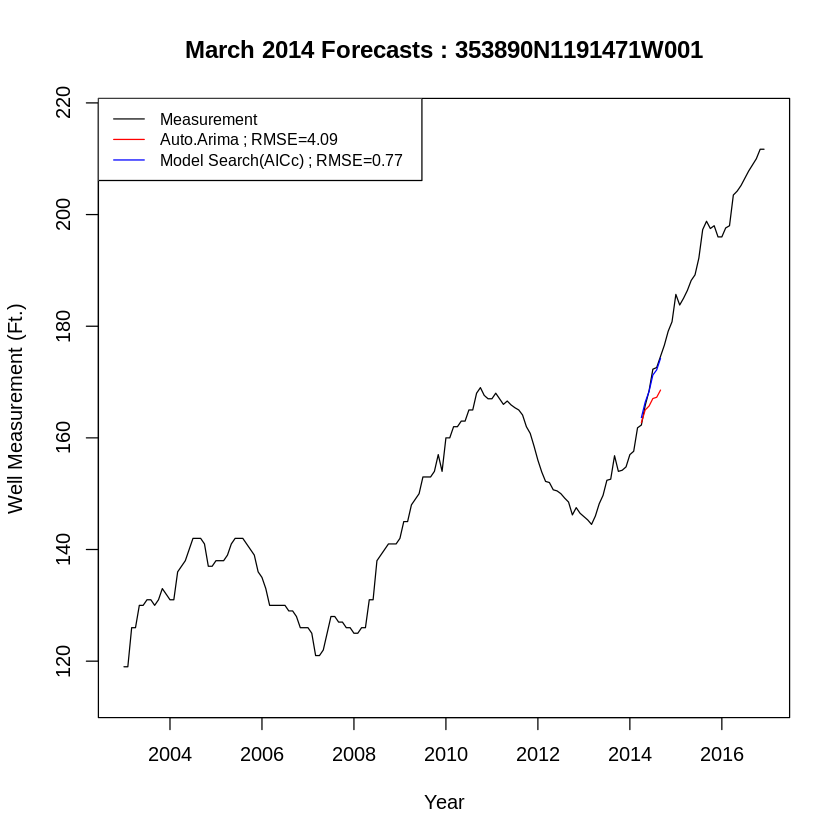

[1] "rmse auto  8.01  RMSE best  6.21"
[1] "########################################"
[1] 2014


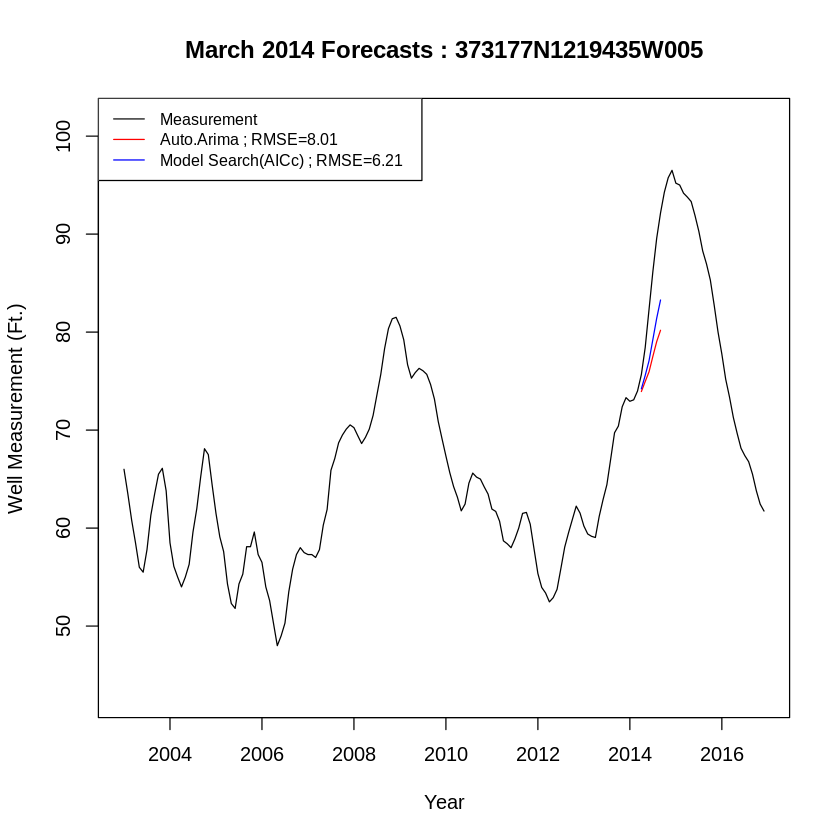

[1] "rmse auto  1.02  RMSE best  0.31"
[1] "########################################"
[1] 2015


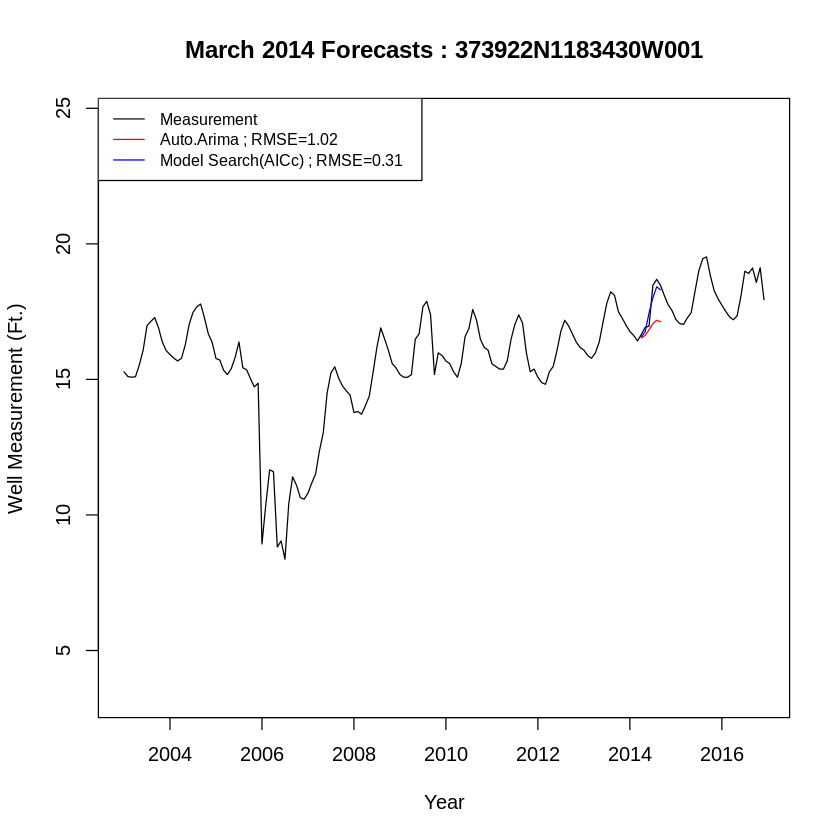

[1] "rmse auto  3.18  RMSE best  7.93"
[1] "########################################"
[1] 2015


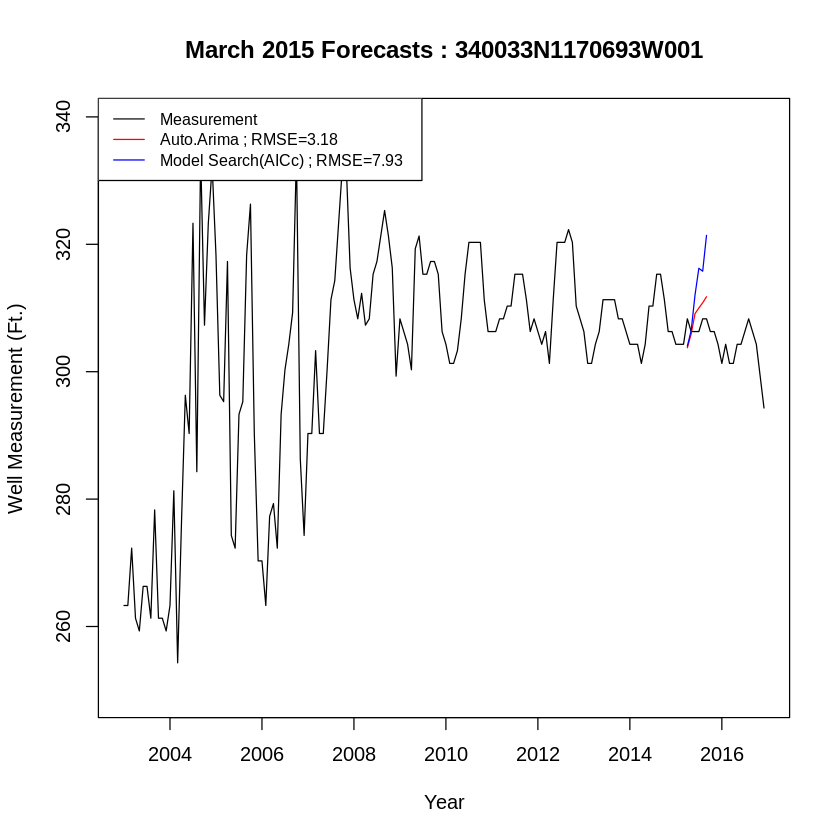

[1] "rmse auto  8.4  RMSE best  1.79"
[1] "########################################"
[1] 2015


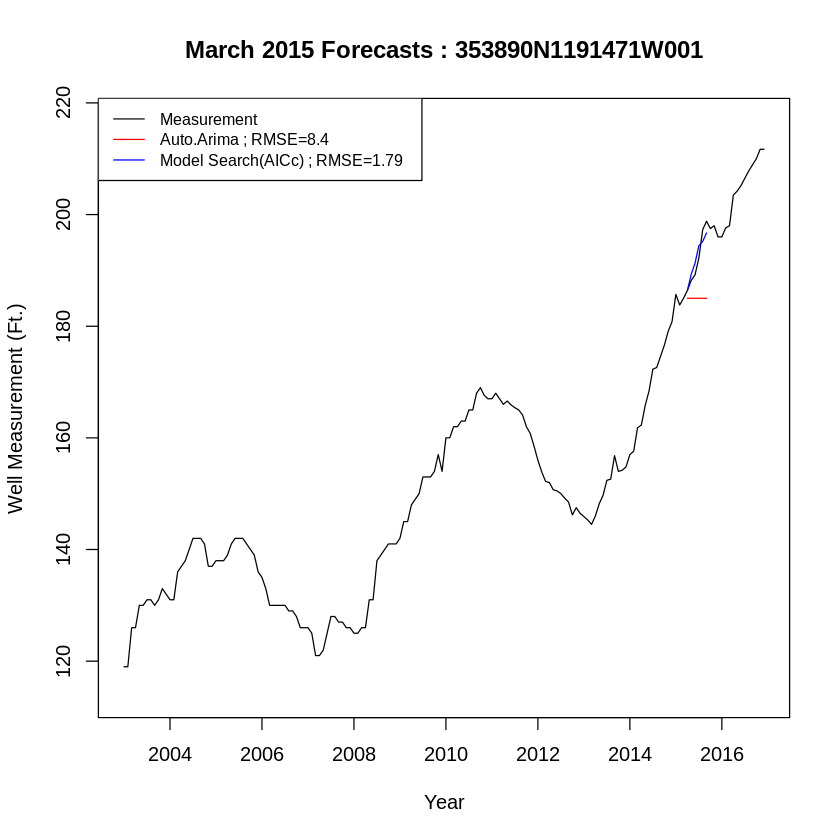

[1] "rmse auto  9.19  RMSE best  9.16"
[1] "########################################"
[1] 2015


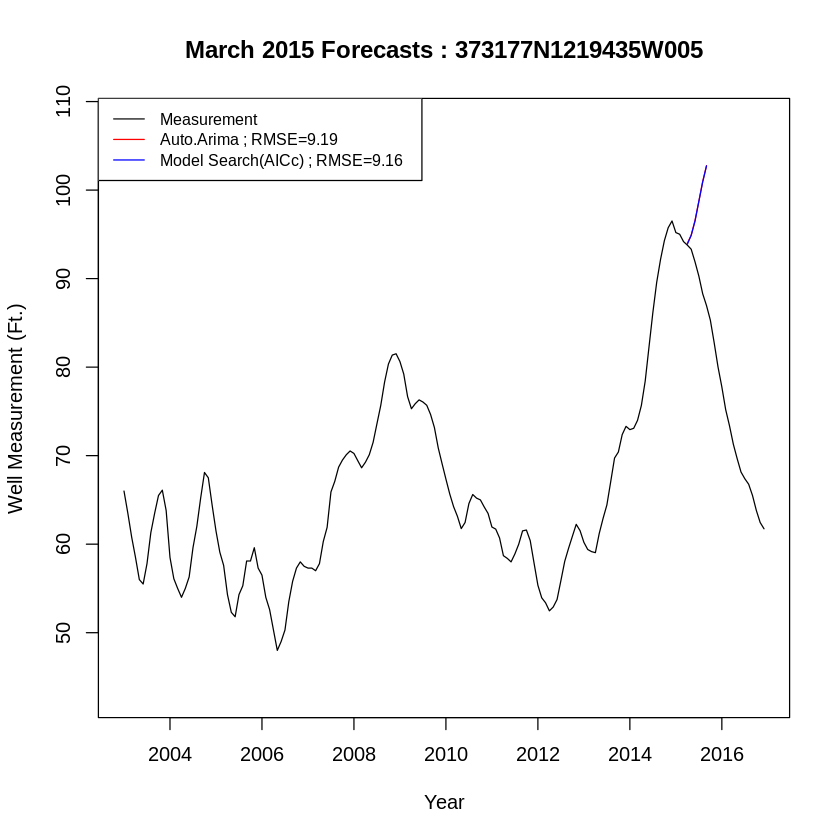

[1] "rmse auto  0.4  RMSE best  0.34"
[1] "########################################"
[1] 2016


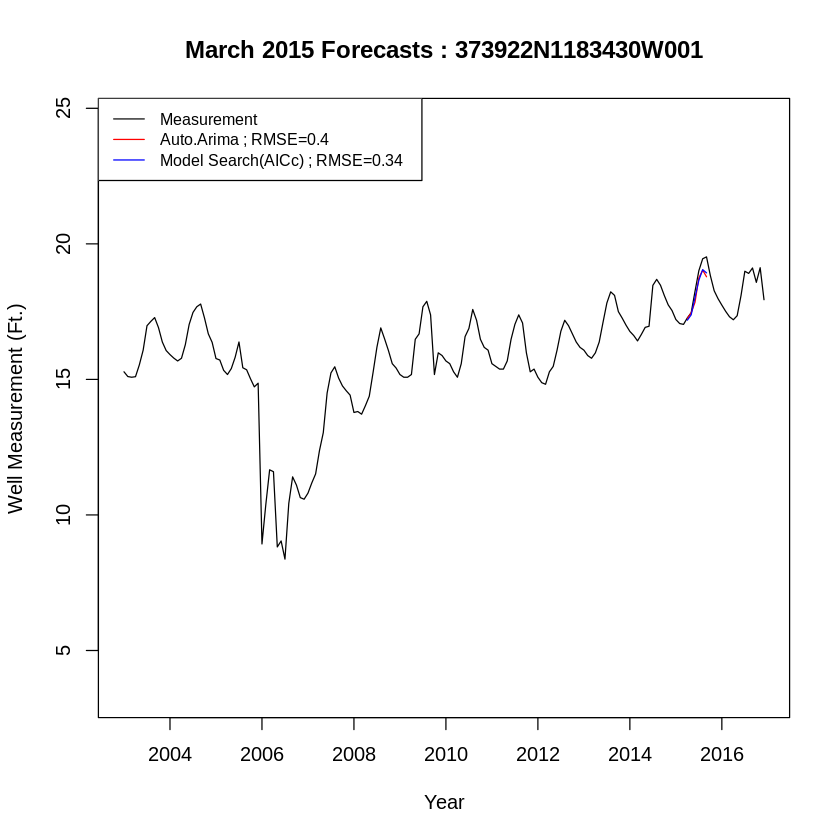

[1] "rmse auto  2.16  RMSE best  5.44"
[1] "########################################"
[1] 2016


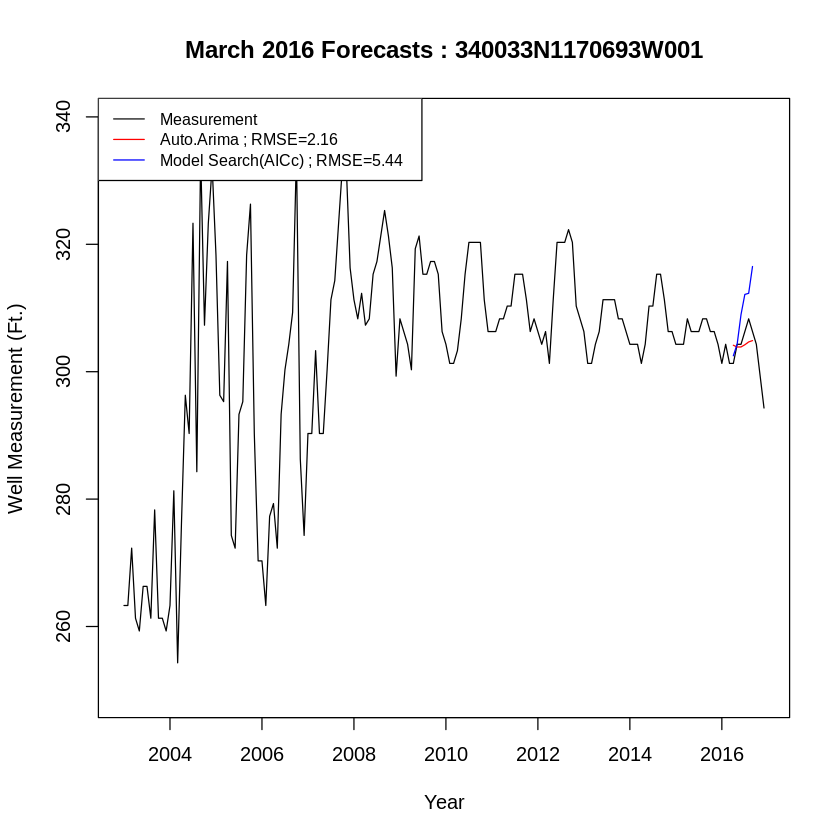

[1] "rmse auto  8.24  RMSE best  3.26"
[1] "########################################"
[1] 2016


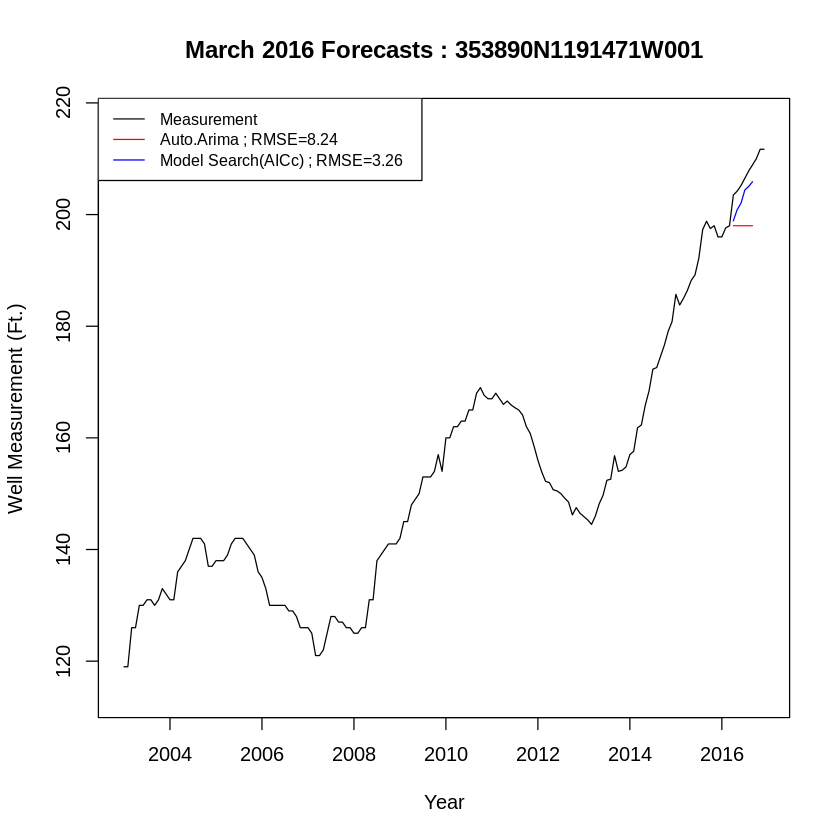

[1] "rmse auto  5.05  RMSE best  5.35"
[1] "########################################"
[1] 2016


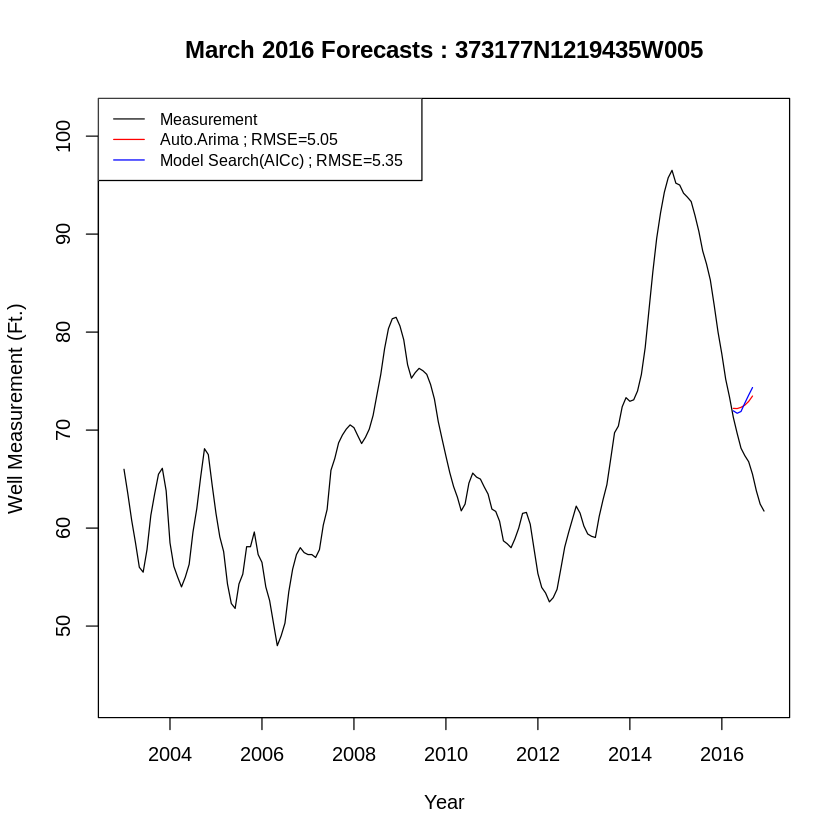

[1] "rmse auto  0.18  RMSE best  0.31"
[1] "########################################"


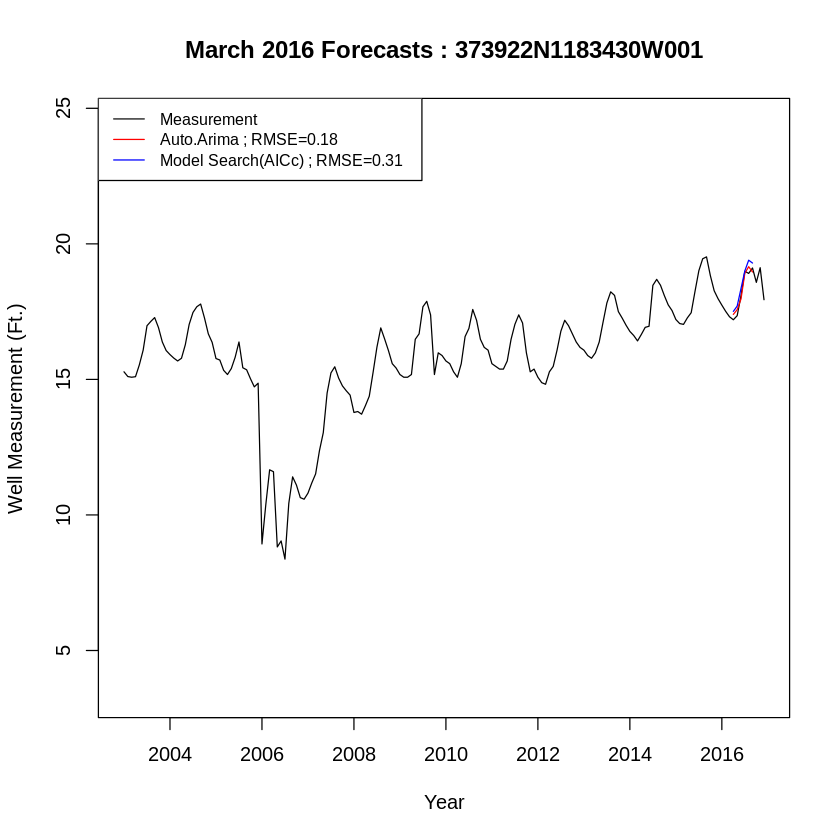

In [4]:

#hold RMSE data
rmsedata_df=data.frame(
    Well=c(),
    Year=c(),
    AutoArimaRMSE=c(),
    BestARIMARMSE=c()
)

#DF to hold real data
real_data=data.frame(
    Well=c(),
    Year=c(),
    Idx=c(),
    Value=c()
)


#months from 2003 ... 2016 are numbered (1-based index from 1 to 168)
# here the month indices are supplied/computed for years in the range
# 2013 to 2016.
indices_df=data.frame(
    Year=c(2013,2014,2015,2016),
    JanIdx=c(121,133,145,157),
    MarIdx=c(121,133,145,157)+2
)

#DF for predictions
predictions_df=data.frame(
    Well=c(),
    Year=c(),
    PredIdx=c(),
    Method=c(),
    Prediction=c()
)


for(year in c(2013,2014,2015,2016)) {
    for(f_idx in 1:length(cnra_files)) {
        print(year)
        yearRows=indices_df[indices_df$Year==year,]
        marIdx=yearRows$MarIdx
        tsd_all=getTSDataFromFileAll(cnra_files[f_idx],num_mos=168)
        tsd=ts(tsd_all[seq(from=1,to=marIdx,by=1)], start=c(2003,1),frequency=12) 
        defaultW <- getOption("warn")
        options(warn = -1)
        #tba=get.best.arima(tsd,maxord=c(2,2,2,2,2,2))
        tba=get.best.arima(tsd)
        best_settings=head(tba,n=1)$model
        #print(paste("best settings ",best_settings))
        best_model=getArimapdqPDQFromModelStr(best_settings,tsd)
        best_model_prediction=predict(best_model,n.ahead = 6)
        for(p in 1:length(best_model_prediction$pred)) {
            temp_row_result=c(getSiteNameFromFile(cnra_files[f_idx]),
                              year,p,"BestArima",best_model_prediction$pred[p])
            predictions_df=rbind(predictions_df,temp_row_result)
            }
        #print("best_model_prediction")
        #print(best_model_prediction$pred)
        options(warn = defaultW)
        arima_model=auto.arima(tsd)
        prediction_auto_arima=0
        auto_had_err=FALSE
        tryCatch({
            temp_prediction_auto_arima=predict(arima_model,n.ahead = 6)
            prediction_auto_arima=temp_prediction_auto_arima$pred
            },error=function(cond) { })
        defaultW <- getOption("warn")
        options(warn = -1)
        if(prediction_auto_arima==0) {
            prediction_auto_arima=rep(tsd[length(tsd)],6)
            auto_had_err=TRUE
        }   
        options(warn = defaultW)
        for(p in 1:length(prediction_auto_arima)) {
            pred_val=prediction_auto_arima[p]
            temp_row_result=c(getSiteNameFromFile(cnra_files[f_idx]),
                              year,p,"AutoArima",pred_val)
            predictions_df=rbind(predictions_df,temp_row_result)
            }
            
        
        main_title=paste("March ",year," Forecasts : ",getSiteNameFromFile(cnra_files[f_idx]),sep="")
        rmses_ret=plotThem(tsd_all,tsd,prediction_auto_arima,best_model_prediction$pred,main_title)
        rmse_auto_arima=rmses_ret[1]
        rmse_best_arima=rmses_ret[2]
        for(m in 1:6) {
            real_data=rbind(real_data,c(getSiteNameFromFile(cnra_files[f_idx]),year,m,rmses_ret[2+m]))
        }
        print(paste("rmse auto ",rmse_auto_arima," RMSE best ",rmse_best_arima))
        rmsedata_df=rbind(rmsedata_df,
                          c(getSiteNameFromFile(cnra_files[f_idx]),
                            as.numeric(year),as.numeric(rmse_auto_arima),as.numeric(rmse_best_arima)))
        print("########################################")
    }
}


### STEP 3.  Tabulate Results ; Include the Min, Mean, and Max for each 6-month period for each model

The min, mean, and max, help provide a range over the 6-month periods.  Those results are written to *CNRA_MinMeanMax.csv*.

In [5]:
colnames(real_data)=c("Well","Year","Idx","Value")
real_data$Value=as.numeric(real_data$Value)
head(real_data)

,Well,Year,Idx,Value
,<chr>,<chr>,<chr>,<dbl>
1,340033N1170693W001,2013,1,304.3
2,340033N1170693W001,2013,2,306.3
3,340033N1170693W001,2013,3,311.3
4,340033N1170693W001,2013,4,311.3
5,340033N1170693W001,2013,5,311.3
6,340033N1170693W001,2013,6,311.3


In [6]:
colnames(predictions_df)=c("Well","Year","PredictionIdx","Method","Prediction")
predictions_df$Prediction=as.numeric(predictions_df$Prediction)
predictions_df

Well,Year,PredictionIdx,Method,Prediction
<chr>,<chr>,<chr>,<chr>,<dbl>
340033N1170693W001,2013,1,BestArima,303.54696
340033N1170693W001,2013,2,BestArima,304.51609
340033N1170693W001,2013,3,BestArima,310.04582
340033N1170693W001,2013,4,BestArima,317.39349
340033N1170693W001,2013,5,BestArima,314.62013
340033N1170693W001,2013,6,BestArima,325.03464
340033N1170693W001,2013,1,AutoArima,300.93959
340033N1170693W001,2013,2,AutoArima,303.58489
340033N1170693W001,2013,3,AutoArima,305.96566


In [7]:
methods=c("AutoArima","BestArima")
mmm_df=data.frame(
    Method=c(),
    Well=c(),
    Year=c(),
    Min=c(),
    Mean=c(),
    Max=c()
)
for(m in methods) {
    for(year in seq(min(predictions_df$Year),max(predictions_df$Year))) {
        for(well in unique(predictions_df$Well)) {
            rows_of_interest=predictions_df[predictions_df$Year==year,]
            rows_of_interest=rows_of_interest[rows_of_interest$Well==well,]
            rows_of_interest=rows_of_interest[rows_of_interest$Method==m,]
            #print(rows_of_interest)
            the_min=min(as.numeric(rows_of_interest$Prediction))
            the_mean=mean(as.numeric(rows_of_interest$Prediction))
            the_max=max(as.numeric(rows_of_interest$Prediction))
            temp_row=c(m,well,year,the_min,the_mean,the_max)
            mmm_df=rbind(mmm_df,temp_row)
            }
        }        
    }
colnames(mmm_df)=c("Method","Well","Year","Min","Mean","Max")
mmm_df$Min=as.numeric(mmm_df$Min)
mmm_df$Mean=as.numeric(mmm_df$Mean)
mmm_df$Max=as.numeric(mmm_df$Max)
mmm_file="CNRA_MinMeanMax.csv"

getMape=function(actual,predicted) {
    numerator=actual-predicted
    denominator=actual
    mape=abs(numerator/denominator)
    return(mape)
}
mape_min_vec=c()
mape_mean_vec=c()
mape_max_vec=c()
for(row_idx in 1:dim(mmm_df)[1]) {
    #print(row_idx)
    this_row_well=mmm_df[row_idx,"Well"]
    this_row_year=mmm_df[row_idx,"Year"]
    actual_values_well=real_data[real_data$Well==this_row_well,]
    acual_values_well_year_rows=actual_values_well[actual_values_well$Year==this_row_year,]
    actual_values=as.numeric(acual_values_well_year_rows$Value)
    mape_min_vec=c(mape_min_vec,getMape(min(actual_values),mmm_df[row_idx,"Min"]))
    mape_mean_vec=c(mape_mean_vec,getMape(mean(actual_values),mmm_df[row_idx,"Mean"]))
    mape_max_vec=c(mape_max_vec,getMape(max(actual_values),mmm_df[row_idx,"Max"]))
}
write.table(mmm_df,mmm_file, append = FALSE, sep = ",")
mmm_df$MAPEMin=as.numeric(mape_min_vec)
mmm_df$MAPEMean=as.numeric(mape_mean_vec)
mmm_df$MAPEMax=as.numeric(mape_max_vec)
mmm_df



Method,Well,Year,Min,Mean,Max,MAPEMin,MAPEMean,MAPEMax
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AutoArima,340033N1170693W001,2013,300.93959,304.81936,306.49472,0.011043091,1.448639e-02,0.015436183
AutoArima,353890N1191471W001,2013,143.27049,143.77481,144.41119,0.018695305,4.753354e-02,0.079010261
AutoArima,373177N1219435W005,2013,58.47824,61.02004,64.54577,0.009514956,4.745495e-02,0.074347225
AutoArima,373922N1183430W001,2013,15.78000,15.78000,15.78000,0.012515645,8.627678e-02,0.134393856
AutoArima,340033N1170693W001,2014,305.01047,306.34910,306.88455,0.012314870,1.007399e-02,0.026690280
AutoArima,353890N1191471W001,2014,162.72050,166.04961,168.56038,0.002590867,1.939208e-02,0.034591169
AutoArima,373177N1219435W005,2014,73.93607,76.92929,80.18889,0.022914378,8.473811e-02,0.129894873
AutoArima,373922N1183430W001,2014,16.52809,16.88931,17.17995,0.007917468,4.553219e-02,0.080794399
AutoArima,340033N1170693W001,2015,303.75606,308.56449,311.76314,0.008305394,4.114842e-03,0.011233019


In [8]:
colnames(rmsedata_df)=c("Well","Year","AutoArimaRMSE","BestARIMARMSE")
rmsedata_df$AutoArimaRMSE=as.numeric(rmsedata_df$AutoArimaRMSE)
rmsedata_df$BestARIMARMSE=as.numeric(rmsedata_df$BestARIMARMSE)

In [9]:
rmsedata_df

Well,Year,AutoArimaRMSE,BestARIMARMSE
<chr>,<chr>,<dbl>,<dbl>
340033N1170693W001,2013,4.60,6.35
353890N1191471W001,2013,8.13,6.79
373177N1219435W005,2013,3.35,3.44
373922N1183430W001,2013,1.72,0.39
340033N1170693W001,2014,5.48,4.79
353890N1191471W001,2014,4.09,0.77
373177N1219435W005,2014,8.01,6.21
373922N1183430W001,2014,1.02,0.31
340033N1170693W001,2015,3.18,7.93


In [10]:
dim(rmsedata_df)

[1] 16  4

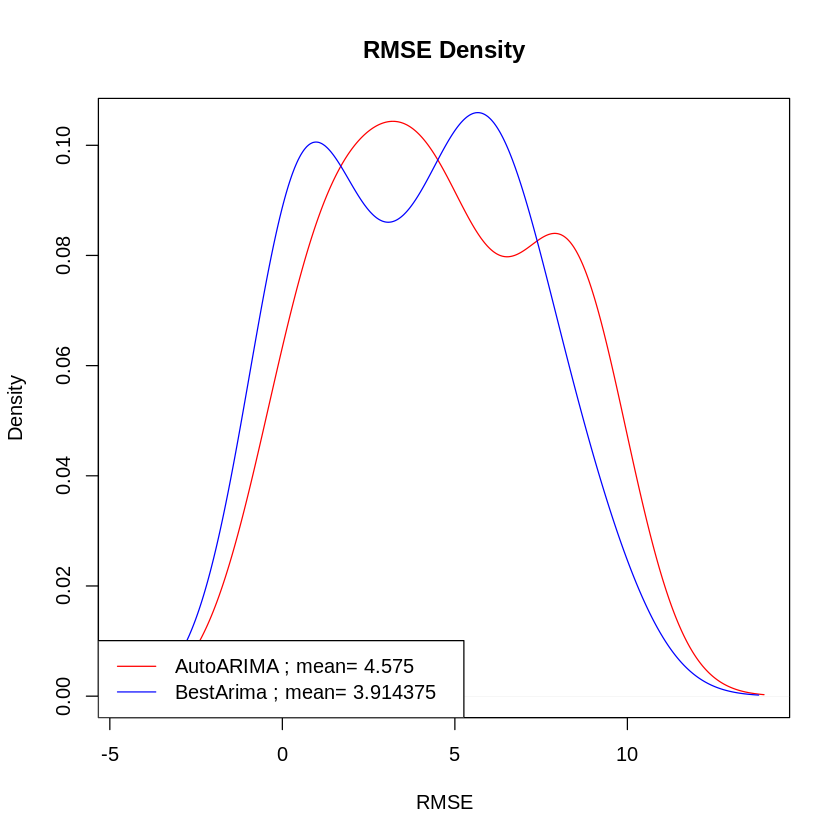

In [11]:
plot(density(as.numeric(rmsedata_df$AutoArimaRMSE)),col="red",main="RMSE Density",xlab="RMSE")
lines(density(as.numeric(rmsedata_df$BestARIMARMSE)),col="blue")
legend(x="bottomleft",legend=c(
    paste("AutoARIMA ; mean=",mean(as.numeric(rmsedata_df$AutoArimaRMSE))),
    paste("BestArima ; mean=",mean(as.numeric(rmsedata_df$BestARIMARMSE)))
    )
       ,col=c("red","blue"),lty=1)

### APPENDIX ARIMA Demonstration

In [12]:
set.seed(102)
ts.sim=arima.sim(n=100,list(ar=c(0.75),ma=c(-0.25)),sd=sqrt(1))
mam=auto.arima(ts.sim)
print("An estimated (1,1,1) ARIMA model:")
print(mam)
last_value=ts.sim[100]
next_to_last_value=ts.sim[99]
print(paste("The last two values of the time series : ",next_to_last_value," and ",last_value))
their_difference=last_value-next_to_last_value
print(paste("Their difference  :",their_difference))
last_residual=mam$residuals[100]
print(paste("The last residual :",last_residual))
ar_coef=as.numeric(mam$coef["ar1"])
ma_coef=as.numeric(mam$coef["ma1"])
manual_prediction=(ar_coef*their_difference)+(ma_coef*last_residual)+last_value
library_prediction=predict(mam,h=1)$pred[1]
print(paste("The manual prediction  : ",manual_prediction))
print(paste("The library prediction : ",library_prediction))

[1] "An estimated (1,1,1) ARIMA model:"
Series: ts.sim 
ARIMA(1,1,1) 

Coefficients:
         ar1      ma1
      0.5081  -0.8808
s.e.  0.1707   0.1190

sigma^2 = 1.121:  log likelihood = -145.44
AIC=296.89   AICc=297.14   BIC=304.67
[1] "The last two values of the time series :  1.27796466523913  and  0.540329669614839"
[1] "Their difference  : -0.737634995624294"
[1] "The last residual : -0.200062349103981"
[1] "The manual prediction  :  0.34177295533218"
[1] "The library prediction :  0.341772955332041"
